### Imports and util functions

In [ ]:
# https://seaborn.pydata.org/examples/structured_heatmap.html
# # try: https://charticulator.com/docs/getting-started.html
# https://www.google.com/search?sxsrf=APq-WBs_fPnKVr4cXjkuib95wDRQSFHl1A:1650583694317&q=heatmap+cluster+lines&tbm=isch&chips=q:heatmap+cluster+lines,online_chips:seaborn+clustermap:znboBaCIRaI%3D&usg=AI4_-kSuFJizVNbAbFIZzug6sEsgaJJHRw&sa=X&ved=2ahUKEwjLh5a2p6b3AhXrAp0JHQRRDYkQgIoDKAF6BAgUEAw&biw=953&bih=973&dpr=1#imgrc=P1hjvfPZPgOQPM&imgdii=QSMll_SYdSnkBM

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import json
from collections import Counter, defaultdict
import ast
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer
from rich.progress import track
import collections
from operator import itemgetter
from tqdm import tqdm
import math
import ast

In [ ]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage


def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage


In [ ]:
with open('data/dict_video_action_pairs_filtered_by_link.json') as json_file:
        dict_video_action_pairs_filtered = json.load(json_file)

In [ ]:
def get_all_action_pairs(dict_video_action_pairs_filtered):
    all_action_pairs = [str(sorted((action_1, action_2)))
                        for video in dict_video_action_pairs_filtered
                        for (action_1, transcript_a1, clip_a1), (action_2, transcript_a2, clip_a2)
                        in dict_video_action_pairs_filtered[video]]

    all_action_pairs = [tuple(ast.literal_eval(action_pair)) for action_pair in all_action_pairs]
    return all_action_pairs

def get_all_actions(all_action_pairs):
    all_actions = []
    for [a1, a2] in all_action_pairs:
        all_actions.append(a1)
        all_actions.append(a2)
    return all_actions

all_action_pairs = get_all_action_pairs(dict_video_action_pairs_filtered)
all_actions = get_all_actions(all_action_pairs)
all_verbs = [action.split()[0] for action in all_actions]
all_verb_pairs = [(action_pair[0].split()[0], action_pair[1].split()[0]) for action_pair in all_action_pairs]

## Error Analysis

In [ ]:
with open('data/results/labels_test.npy', 'rb') as f:
    labels_test = np.load(f, allow_pickle=True)
with open('data/results/nodes_test.npy', 'rb') as f:
    nodes_test = np.load(f, allow_pickle=True)
# with open('data/results/predicted_SVM_all_txt_vis_embeddings_all_heuristics.npy', 'rb') as f:
with open('data/results/predicted_SVM_stsbrt.npy', 'rb') as f:
    predicted_labels = np.load(f)

In [ ]:
nodes_name_pairs = [(nodes_test[i][0], nodes_test[i][1]) for i in range(len(nodes_test))]

dict_results_correct = defaultdict()
dict_results_errors = {"FP": {}, "FN": {}}
for i, (predicted, gt) in enumerate(zip(predicted_labels, labels_test)):
    if predicted == gt:
        dict_results_correct[nodes_name_pairs[i]] = all_actions.count(nodes_name_pairs[i][0]) + all_actions.count(
            nodes_name_pairs[i][1])
    elif predicted == 0 and gt == 1:
        dict_results_errors["FN"][nodes_name_pairs[i]] = all_actions.count(
            nodes_name_pairs[i][0]) + all_actions.count(nodes_name_pairs[i][1])
    else:
        dict_results_errors["FP"][nodes_name_pairs[i]] = all_actions.count(
            nodes_name_pairs[i][0]) + all_actions.count(nodes_name_pairs[i][1])

print("#FN", str(len(dict_results_errors["FN"])))
# print(dict(sorted(dict_results_errors["FN"].items()), key=lambda item: item[0]))
print("#FP", str(len(dict_results_errors["FP"])))
# print(dict(sorted(dict_results_errors["FP"].items()), key=lambda item: item[0]))
print("#TP + TN", len(dict_results_correct))

In [ ]:
dict_freq = {}
dict_actions = {}
dict_verbs = {}
dict_actions_pair = {}
list_results = []

for action_pair, gt, predicted in zip(nodes_test, labels_test, predicted_labels):
    [action1, action2] = list(action_pair)
    verb1 = action1.split()[0]
    verb2 = action2.split()[0]
    pair_freq = all_action_pairs.count((action1, action2))
#     pair_freq = all_actions.count(action1) + all_actions.count(action2)
    if pair_freq not in dict_freq:
        dict_freq[pair_freq] = []
    if str([action1, action2]) not in dict_actions_pair:
        dict_actions_pair[str([action1, action2])] = []
    if action1 not in dict_actions:
        dict_actions[action1] = []
    if action2 not in dict_actions:
        dict_actions[action2] = []
    if verb1 not in dict_verbs:
        dict_verbs[verb1] = []
    if verb2 not in dict_verbs:
        dict_verbs[verb2] = []
        
    if gt == predicted:
        dict_freq[pair_freq].append(1)
        dict_actions_pair[str([action1, action2])].append(1)
        dict_actions[action1].append(1)
        dict_actions[action2].append(1)
        dict_verbs[verb1].append(1)
        dict_verbs[verb2].append(1)
    else:
        dict_freq[pair_freq].append(0)
        dict_actions_pair[str([action1, action2])].append(0)
        dict_actions[action1].append(0)
        dict_actions[action2].append(0)
        dict_verbs[verb1].append(0)
        dict_verbs[verb2].append(0)
#     if pair_freq == 12 or pair_freq == 21:
#         print([action1, action2], pair_freq, gt, predicted)
#     print(action1, action2, pair_freq, gt, predicted)

for freq in dict_freq:
    dict_freq[freq] = round(sum(dict_freq[freq]) / len(dict_freq[freq]), 2)   
for action_pair in dict_actions_pair:
    dict_actions_pair[action_pair] = round(sum(dict_actions_pair[action_pair]) / len(dict_actions_pair[action_pair]), 2)
for action in dict_actions:
    dict_actions[action] = round(sum(dict_actions[action]) / len(dict_actions[action]), 2)
for verb in dict_verbs:
    dict_verbs[verb] = round(sum(dict_verbs[verb]) / len(dict_verbs[verb]), 2)

dict_freq = collections.OrderedDict(sorted(dict_freq.items()))
dict_actions_pair = collections.OrderedDict(sorted(dict_actions_pair.items()))

# my_rho = np.corrcoef(list(dict_freq.keys()), list(dict_freq.values()))
# my_rho

# dict_actions = collections.OrderedDict(sorted(dict_actions.items(), key=itemgetter(1)))
# dict_verbs = collections.OrderedDict(sorted(dict_verbs.items(), key=itemgetter(1)))

# # dict_actions
# dict_verbs

accuracy, action_count = [], [] 
# for action, avg_acc in dict_actions.items():
# for action, avg_acc in dict_verbs.items():
for action_pair, avg_acc in dict_actions_pair.items():
#     count = all_actions.count(action)
#     count = all_verbs.count(action)
    [action1, action2] = ast.literal_eval(action_pair)
    count = all_action_pairs.count((action1, action2))
#     print(action_pair, avg_acc, count)
    accuracy.append(avg_acc)
    action_count.append(count)
    
my_rho = np.corrcoef(accuracy, action_count)
my_rho


# sns.set_theme(style="darkgrid")
# plt.tight_layout()
# ax = sns.barplot(x=keys, y=vals, color='purple')
# for bars in ax.containers:
#     ax.bar_label(bars)
# ax.set_xlabel("Action Pair Frequency", fontsize = 10)
# ax.set_ylabel("Average Accuracy", fontsize = 10)
# plt.savefig('data/plots/results_action_pair_freq.pdf', bbox_inches='tight')

## Data analysis (distribution)

In [ ]:
# sns.set_theme(style="darkgrid")
list_counts=list(Counter(all_actions).values())
g1 = sns.displot(list_counts, bins=100, kde=True)
plt.tight_layout()
plt.savefig('data/plots/action_distrib.pdf', bbox_inches='tight')

In [ ]:
for (action_pair, freq) in Counter(all_action_pairs).most_common()[:20]:
# for (action_pair, freq) in Counter(all_action_pairs).most_common()[-20:]:
    print(f"{action_pair[0]}, {action_pair[1]} & {freq} \\\ ")

## Action co-occurrence

In [ ]:
def calculate_PMI(all_actions, all_action_pairs, file_out):
    N = len(all_actions)
    M = len(all_action_pairs)
    threshold = 10
    pmi_action_pairs = defaultdict()
    for action_pair in track(set(all_action_pairs), description="Computing PMI..."):
        (a1, a2) = action_pair
        if all_actions.count(a1) < threshold or all_actions.count(a2) < threshold:
            pmi_action_pairs[str((a1, a2))] = 0
        else:
            # weighting PMI: • Raise the context probabilities to alpha = 0.75
            # http://www.cs.umd.edu/class/fall2018/cmsc470/slides/slides_02.pdf
            # alpha = 0.75
            norm_count_a1_a2 = all_action_pairs.count((a1, a2)) / M
            norm_count_a1 = all_actions.count(a1) / N
            norm_count_a2 = all_actions.count(a2) / N
            # norm_count_a1 = all_actions.count(a1) ** alpha / N
            # norm_count_a2 = all_actions.count(a2) ** alpha / N
            PMI_a1_a2 = max(0, int(math.log2(norm_count_a1_a2 / (norm_count_a1 * norm_count_a2))))
            pmi_action_pairs[str((a1, a2))] = PMI_a1_a2

    with open(file_out, 'w+') as fp:
        json.dump(pmi_action_pairs, fp)

In [ ]:
calculate_PMI(all_actions, all_action_pairs, file_out='data/dict_pmi_action_pairs.json')
calculate_PMI(all_verbs, all_verb_pairs, file_out='data/dict_pmi_verb_pairs.json')

In [ ]:
with open('data/dict_pmi_action_pairs.json') as json_file:
    dict_pmi_action_pairs = json.load(json_file)

In [ ]:
top_20 = sorted([(k, v) for k, v in dict_pmi_action_pairs.items() if v != "None"], key=lambda x: x[1])[-20:]
last_20 = sorted([(k, v) for k, v in dict_pmi_action_pairs.items() if v != "None"], key=lambda x: x[1])[:20]
print(top_20)
print(last_20)

In [ ]:
# Co-occurrence of most common actions
nb_actions = 20
most_common_actions = [action for (action, count) in Counter(all_actions).most_common(nb_actions)]
all_action_pairs_most_common = [[a1, a2] for [a1, a2] in all_action_pairs if a1 in most_common_actions and a2 in most_common_actions]
all_action_pairs_most_common += [[a2, a1] for [a1, a2] in all_action_pairs if a1 in most_common_actions and a2 in most_common_actions]

for a in most_common_actions:
    if [a, a] not in all_action_pairs_most_common:
        all_action_pairs_most_common += [[a, a]]
    
all_action_pairs_most_common

In [ ]:
df_actions = pd.DataFrame(all_action_pairs_most_common, columns=['action1', 'action2'])
df_actions

In [ ]:
#convert to co-occurrance matrix
co_mat_actions = pd.crosstab(df_actions.action1, df_actions.action2)
co_mat_actions

In [ ]:
co_mat_actions_norm = co_mat_actions.copy()
for action1 in tqdm(most_common_actions):
    for action2 in most_common_actions:
        action_pair = str(tuple(sorted((action1, action2))))
        if action_pair in dict_pmi_action_pairs:
            co_mat_actions_norm[action1][action2] = dict_pmi_action_pairs[action_pair]
        else:
#             co_mat_actions_norm[action1][action2] = -100
            co_mat_actions_norm[action1][action2] = 0
        if action1 == action2:
            co_mat_actions_norm[action1][action2] = 0
co_mat_actions_norm

In [ ]:
array_co_mat_actions_norm = np.array(co_mat_actions_norm)
array_co_mat_actions_norm.shape

In [ ]:
dist_mat = array_co_mat_actions_norm
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.show()

In [ ]:
methods = ["ward","single","average","complete"]
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat, method)
    
    plt.pcolormesh(ordered_dist_mat)
    plt.colorbar()
    plt.show()

In [ ]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat, method='ward')
most_common_actions_mat = list(co_mat_actions_norm.columns)
labels = [most_common_actions_mat[r] for r in res_order]
# labels = most_common_actions
ax = plt.gca()
# ax.set_xticks(np.linspace(1,len(labels),num=len(labels)))
# ax.set_yticks(np.linspace(1,len(labels), num=len(labels)))
plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.show()

# plt.gcf().savefig("abc.svg", bbox_inches='tight')

In [ ]:
df = pd.DataFrame(ordered_dist_mat, columns = labels, index = labels)
df

In [ ]:
df_good = df.copy()
for action1 in tqdm(most_common_actions):
    for action2 in most_common_actions:
        action_pair = str(tuple(sorted((action1, action2))))
        if action1 == action2 and str(action_pair) in dict_pmi_action_pairs:
            df_good[action1][action2] = dict_pmi_action_pairs[str(action_pair)]
df_good

In [ ]:
# plot heat map of verb co-occurrance matrix
sns.set(font_scale = 3)
plt.figure(figsize=(17, 17))

# sns.set(font_scale = 1.5)
# plt.figure(figsize=(21, 21))

# plt.figure(figsize=(45, 45))
# mask = np.zeros_like(df_good)
# mask[np.triu_indices_from(mask)] = True
#TODO: TRY CLUSTERMAP

## we do this because some actions are too long and mess the figure
df_new = df_good.rename(columns={'add teaspoon of maple syrup': 'add maple syrup'}, index={'add teaspoon of maple syrup': 'add maple syrup'})
labels = list(map(lambda x: x.replace('add teaspoon of maple syrup', 'add maple syrup'), labels))

ax = sns.heatmap(df_new, square=True, cmap='BuPu', vmin=0, linewidths=.2, linecolor='white', cbar_kws={"shrink": .50}, fmt='.2f',
            xticklabels=labels, yticklabels=labels) #df mask=mask 

ax.axes.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(left=False, top=False)

# ax.invert_yaxis()
# plt.savefig('data/plots/co-occurrence_actions_20.pdf', bbox_inches='tight')
# plt.savefig('data/plots/co-occurrence_actions_50.pdf', bbox_inches='tight')

## Co-occurence only verbs

In [ ]:
all_verbs = [action.split()[0] for action in all_actions]

In [ ]:
all_verb_pairs = [(action_pair[0].split()[0], action_pair[1].split()[0]) for action_pair in all_action_pairs]

In [ ]:
with open('data/dict_pmi_verb_pairs.json') as json_file:
    dict_pmi_verb_pairs = json.load(json_file)


In [ ]:
nb_verbs = 50
most_common_verbs = [verb for (verb, count) in Counter(all_verbs).most_common(nb_verbs)]
all_verb_pairs_most_common = [[a1, a2] for [a1, a2] in all_verb_pairs if a1 in most_common_verbs and a2 in most_common_verbs]
all_verb_pairs_most_common += [[a2, a1] for [a1, a2] in all_verb_pairs if a1 in most_common_verbs and a2 in most_common_verbs]

In [ ]:
# for (verb_pair, freq) in Counter(all_verb_pairs).most_common()[:20]:
for (verb_pair, freq) in Counter(all_verb_pairs).most_common()[-20:]:
    print(f"{verb_pair[0]}, {verb_pair[1]} & {freq} \\\ ")

In [ ]:
df = pd.DataFrame(all_verb_pairs_most_common, columns=['verb1', 'verb2'])
df

In [ ]:
#convert to co-occurance matrix
co_mat_verb = pd.crosstab(df.verb1, df.verb2)
co_mat_verb

In [ ]:
co_mat_verb_norm = co_mat_verb.copy()
for verb1 in tqdm(most_common_verbs):
    for verb2 in most_common_verbs:
        verb_pair = str(tuple(sorted((verb1, verb2))))
        if verb_pair in dict_pmi_verb_pairs:
            co_mat_verb_norm[verb1][verb2] = dict_pmi_verb_pairs[verb_pair]
        else:
            co_mat_verb_norm[verb1][verb2] = 0
        if verb1 == verb2:
            co_mat_verb_norm[verb1][verb2] = 0
co_mat_verb_norm

In [ ]:
array_co_mat_verbs_norm = np.array(co_mat_verb_norm)
array_co_mat_verbs_norm.shape

In [ ]:
dist_mat = array_co_mat_verbs_norm
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.show()

In [ ]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat, method='average')
most_common_verbs_mat = list(co_mat_verb_norm.columns)
labels = [most_common_verbs_mat[r] for r in res_order]

# fig, ax = plt.subplots()
# fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

ax = plt.gca()
# ax.set_xticks(np.linspace(1,len(labels),num=len(labels)))
# ax.set_yticks(np.linspace(1,len(labels), num=len(labels)))
plt.pcolormesh(ordered_dist_mat)
plt.colorbar()

# Set ticks in center of cells
ax.set_xticks(np.arange(ordered_dist_mat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(ordered_dist_mat.shape[0]) + 0.5, minor=False)

# Rotate the xlabels. Set both x and y labels to headers[1:]
ax.set_xticklabels(labels,rotation=90)
ax.set_yticklabels(labels)

plt.show()

In [ ]:
df = pd.DataFrame(ordered_dist_mat, columns = labels, index = labels)
df

In [ ]:
df_good = df.copy()
for verb1 in tqdm(most_common_verbs):
    for verb2 in most_common_verbs:
        verb_pair = str(tuple(sorted((verb1, verb2))))
        if verb1 == verb2 and str(verb_pair) in dict_pmi_verb_pairs:
            df_good[verb1][verb2] = dict_pmi_verb_pairs[str(verb_pair)]
df_good

In [ ]:
# plot heat map of verb co-occurrance matrix
sns.set(font_scale = 2)
plt.figure(figsize=(21, 21))
# plt.figure(figsize=(45, 45))
# mask = np.zeros_like(df_good)
# mask[np.triu_indices_from(mask)] = True
#TODO: TRY CLUSTERMAP
ax = sns.heatmap(df_good, square=True, cmap='BuPu', vmin=0, linewidths=.2, cbar_kws={"shrink": .50}, fmt='.2f',
            xticklabels=labels, yticklabels=labels) #df mask=mask 
# ax.invert_yaxis()

ax.axes.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(left=False, top=False)

# plt.savefig('data/plots/co-occurrence_verbs_20.pdf', bbox_inches='tight')
plt.savefig('data/plots/co-occurrence_verbs_50.pdf', bbox_inches='tight')

In [ ]:
# plt.spy()
# plt.matshow(co_mat_verb_norm.to_numpy());
# plt.colorbar()
# plt.show()
plt.spy(co_mat_verb_norm.to_numpy())

In [ ]:
def count_nb_co_occurences(verb):
    count = 0
    for [v1, v2] in set(all_verb_pairs):
        if v1 == verb or v2 == verb:
            count += 1
    return count

In [ ]:
dict_non_zero = defaultdict(list)
matrix = co_mat_verb_norm.to_numpy()
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            dict_non_zero[i].append((j, matrix[i][j]))
    dict_non_zero[i] = sorted(dict_non_zero[i], key= lambda x: x[1], reverse=True)
dict_non_zero

dict_verb = defaultdict()
for verb in set(all_verbs):
    dict_verb[verb] = count_nb_co_occurences(verb)

dict_verb_sorted = {k: v for k, v in sorted(dict_verb.items(), key=lambda item: item[1], reverse = True)}
most_co_occurring_verbs = [(k,v) for k, v in dict_verb_sorted.items()][:10]
least_co_occurring_verbs = [(k,v) for k, v in dict_verb_sorted.items()][-10:]

print(len(set(all_verbs)))
print(most_co_occurring_verbs)
print(least_co_occurring_verbs)

## Action clustering

### Use for tSNE clusters

In [ ]:
from sklearn.neighbors import NearestNeighbors
# !pip install adjustText
import matplotlib.pyplot as plt 
import random
from adjustText import adjust_text # this package corrects the label overlap. I installed it with conda/ pip in my virtual env
from sklearn.manifold import TSNE # This transforms the data from a high dimensional vector (768d in this case) to a 2d one, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [ ]:
def make_color_dict(clusters):  #TODO: color_list should be changed to automatic list based on number of clusters
    color_dict = {}
    # color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    color_list = []
    color_list = sns.color_palette("hls", len(clusters))
    n = len(clusters)
    # for i in range(n):
    #     r = random.randint(0, 10)
    #     g = random.randint(0, 10)
    #     b = random.randint(0, 10)
    #     color_list.append((float(r)/10, float(g)/10, float(b)/10))
    for i, key in enumerate(clusters.keys()):
        color_dict[key] = color_list[i]
    return color_dict

In [ ]:
def get_key_by_val(clusters, val):
    for k in clusters.keys():
        values = clusters[k]
        if val in values:
            return k

In [ ]:
def tsne_plot_2d(clusters, embeddings, actions):
    sns.set_style("white")
    plt.figure(figsize=(16, 13))
    color_dict = make_color_dict(clusters)
    texts = []
    cluster_dict = {}
    for embedding, action in zip(embeddings, actions):
        x = embedding[0]
        y = embedding[1]

        cluster_key = get_key_by_val(clusters, action)
        if not cluster_key:
            continue
#         print(cluster_key)
        color = color_dict[cluster_key]
        
        if cluster_key not in cluster_dict:
            plt.scatter(x, y, color=color, s=100, label=cluster_key)
            cluster_dict[cluster_key] = []
        else:
            plt.scatter(x, y, color=color, s=100)
        cluster_dict[cluster_key].append((x, y, action))
            
    for id in cluster_dict:
        points = cluster_dict[id]
        for point in points:
            texts.append(plt.text(point[0], point[1], point[2], ha='right', va='bottom', size=21, color = color_dict[id], wrap=True))
    adjust_text(texts)

    # plt.grid(True)
    # plt.legend(loc=1, prop={'size': 15})
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          ncol=4, shadow=True, prop={'size': 20})
    # Turn off tick labels
    plt.yticks([])
    plt.xticks([])
    plt.savefig("data/plots/clusters.pdf", bbox_inches = "tight")

In [ ]:
# SentenceBert embeddings
from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('stsb-roberta-base')

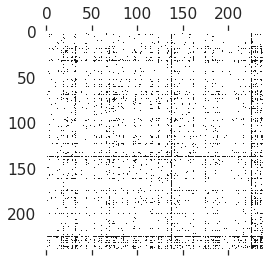

In [52]:
# plt.spy()
# plt.matshow(co_mat_verb_norm.to_numpy());
# plt.colorbar()
# plt.show()
plt.spy(co_mat_verb_norm.to_numpy())

In [36]:
def count_nb_co_occurences(verb):
    count = 0
    for [v1, v2] in set(all_verb_pairs):
        if v1 == verb or v2 == verb:
            count += 1
    return count

In [37]:
dict_non_zero = defaultdict(list)
matrix = co_mat_verb_norm.to_numpy()
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            dict_non_zero[i].append((j, matrix[i][j]))
    dict_non_zero[i] = sorted(dict_non_zero[i], key= lambda x: x[1], reverse=True)
dict_non_zero

dict_verb = defaultdict()
for verb in set(all_verbs):
    dict_verb[verb] = count_nb_co_occurences(verb)

dict_verb_sorted = {k: v for k, v in sorted(dict_verb.items(), key=lambda item: item[1], reverse = True)}
most_co_occurring_verbs = [(k,v) for k, v in dict_verb_sorted.items()][:10]
least_co_occurring_verbs = [(k,v) for k, v in dict_verb_sorted.items()][-10:]

print(len(set(all_verbs)))
print(most_co_occurring_verbs)
print(least_co_occurring_verbs)

164
[('use', 137), ('put', 127), ('add', 112), ('clean', 72), ('cut', 69), ('wash', 56), ('eat', 56), ('wear', 52), ('hold', 47), ('stick', 45)]
[('hunt', 1), ('grind', 1), ('shred', 1), ('wind', 1), ('sprain', 1), ('chase', 1), ('inject', 1), ('photograph', 1), ('spritz', 1), ('kiss', 1)]


## Action clustering

### Use for tSNE clusters

In [73]:
from sklearn.neighbors import NearestNeighbors
# !pip install adjustText
import matplotlib.pyplot as plt 
import random
from adjustText import adjust_text # this package corrects the label overlap. I installed it with conda/ pip in my virtual env
from sklearn.manifold import TSNE # This transforms the data from a high dimensional vector (768d in this case) to a 2d one, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [74]:
def make_color_dict(clusters):  #TODO: color_list should be changed to automatic list based on number of clusters
    color_dict = {}
    # color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    color_list = []
    color_list = sns.color_palette("hls", len(clusters))
    n = len(clusters)
    # for i in range(n):
    #     r = random.randint(0, 10)
    #     g = random.randint(0, 10)
    #     b = random.randint(0, 10)
    #     color_list.append((float(r)/10, float(g)/10, float(b)/10))
    for i, key in enumerate(clusters.keys()):
        color_dict[key] = color_list[i]
    return color_dict

In [75]:
def get_key_by_val(clusters, val):
    for k in clusters.keys():
        values = clusters[k]
        if val in values:
            return k

In [76]:
def tsne_plot_2d(clusters, embeddings, actions):
    sns.set_style("white")
    plt.figure(figsize=(16, 13))
    color_dict = make_color_dict(clusters)
    texts = []
    cluster_dict = {}
    for embedding, action in zip(embeddings, actions):
        x = embedding[0]
        y = embedding[1]

        cluster_key = get_key_by_val(clusters, action)
        if not cluster_key:
            continue
#         print(cluster_key)
        color = color_dict[cluster_key]
        
        if cluster_key not in cluster_dict:
            plt.scatter(x, y, color=color, s=100, label=cluster_key)
            cluster_dict[cluster_key] = []
        else:
            plt.scatter(x, y, color=color, s=100)
        cluster_dict[cluster_key].append((x, y, action))
            
    for id in cluster_dict:
        points = cluster_dict[id]
        for point in points:
            texts.append(plt.text(point[0], point[1], point[2], ha='right', va='bottom', size=21, color = color_dict[id], wrap=True))
    adjust_text(texts)

    # plt.grid(True)
    # plt.legend(loc=1, prop={'size': 15})
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          ncol=4, shadow=True, prop={'size': 20})
    # Turn off tick labels
    plt.yticks([])
    plt.xticks([])
    plt.savefig("data/plots/clusters.pdf", bbox_inches = "tight")

In [77]:
# SentenceBert embeddings
from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('stsb-roberta-base')

In [78]:
with open('data/dict_clustered_actions.json') as json_file:
    dict_clustered_actions = json.load(json_file)

In [79]:
# get biggest clusters
for key in sorted(dict_clustered_actions, key=lambda k : len(dict_clustered_actions[k]), reverse=True)[:10]:
    print(key, len(dict_clustered_actions[key]))

film for guy 68
clean area 46
use type 46
pick bag 44
add oil 44
cut piece 43
wear top 43
add water 43
add egg 41
wash hair 40


In [84]:
# get most frequent clusters
# print(Counter(all_actions).most_common(20))
# counts_all_actions = list(Counter(all_actions).values())
# sns.displot(counts_all_actions)
most_freq_clusters = {k:dict_clustered_actions[k][:5] for (k, _) in Counter(all_actions).most_common(10)}
least_freq_clusters = {k:dict_clustered_actions[k][:5] for (k, _) in Counter(all_actions).most_common()[-10:]}

freq_actions_clusters = list(set([s1 for s in most_freq_clusters.values() for s1 in s]))
least_freq_actions_clusters = list(set([s1 for s in least_freq_clusters.values() for s1 in s]))

freq_sentence_embeddings = model.encode(freq_actions_clusters)
least_freq_sentence_embeddings = model.encode(least_freq_actions_clusters)

most_freq_clusters

{'add oil': ['launch oil',
  'soak oil',
  'rid of oil',
  'pull oil from pore',
  'shake oil'],
 'add cup': ['drink cup',
  'serve in cup',
  'stir third of cup',
  'stack mug',
  'pour into cup'],
 'add water': ['wash under water',
  'mix water',
  'provide hydration',
  'use water',
  'drink water'],
 'put top': ['set top', 'sew top', 'hold top', 'sit over top', 'use top'],
 'cut piece': ['cut height',
  'cut layer',
  'cut present',
  'cut r',
  'put cutout shape'],
 'put bowl': ['color in bowl',
  'serve in bowl',
  'flip bowl',
  'pour into bowl',
  'fill bowl'],
 'use type': ['use cent worth',
  'use to city',
  'use layer',
  'use piece',
  'use set'],
 'clean sink': ['clear bathtub',
  'clean soap station',
  'clean faucet',
  'clean of soap',
  'clean tub'],
 'add egg': ['eat egg',
  'pour egg',
  'place egg on rack',
  'paint recyclable egg carton',
  'pick egg'],
 'add onion': ['eat onion',
  'stir onion',
  'remove layer of onion',
  'burn onion',
  'chop onion']}

In [81]:
# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0) #n_components is the dimension of the vector

/home/oignat/.pyenv/versions/action_order/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


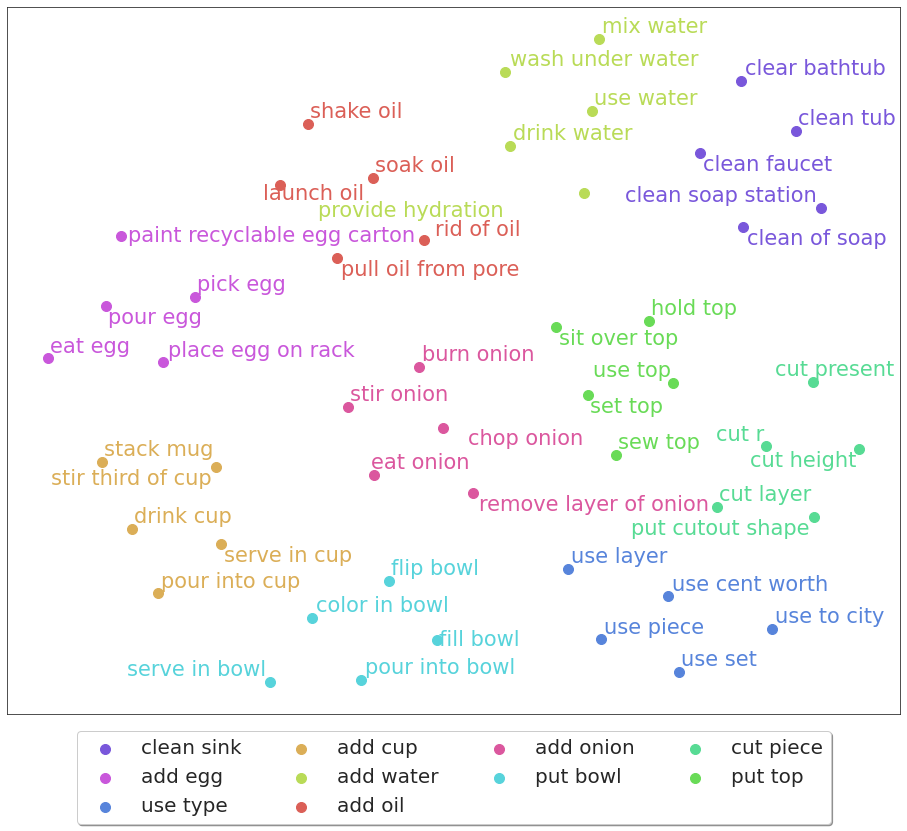

In [83]:
sentence_embeddings_proj_2d = tsne.fit_transform(freq_sentence_embeddings)
tsne_plot_2d(most_freq_clusters, sentence_embeddings_proj_2d, freq_actions_clusters)

/home/oignat/.pyenv/versions/action_order/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


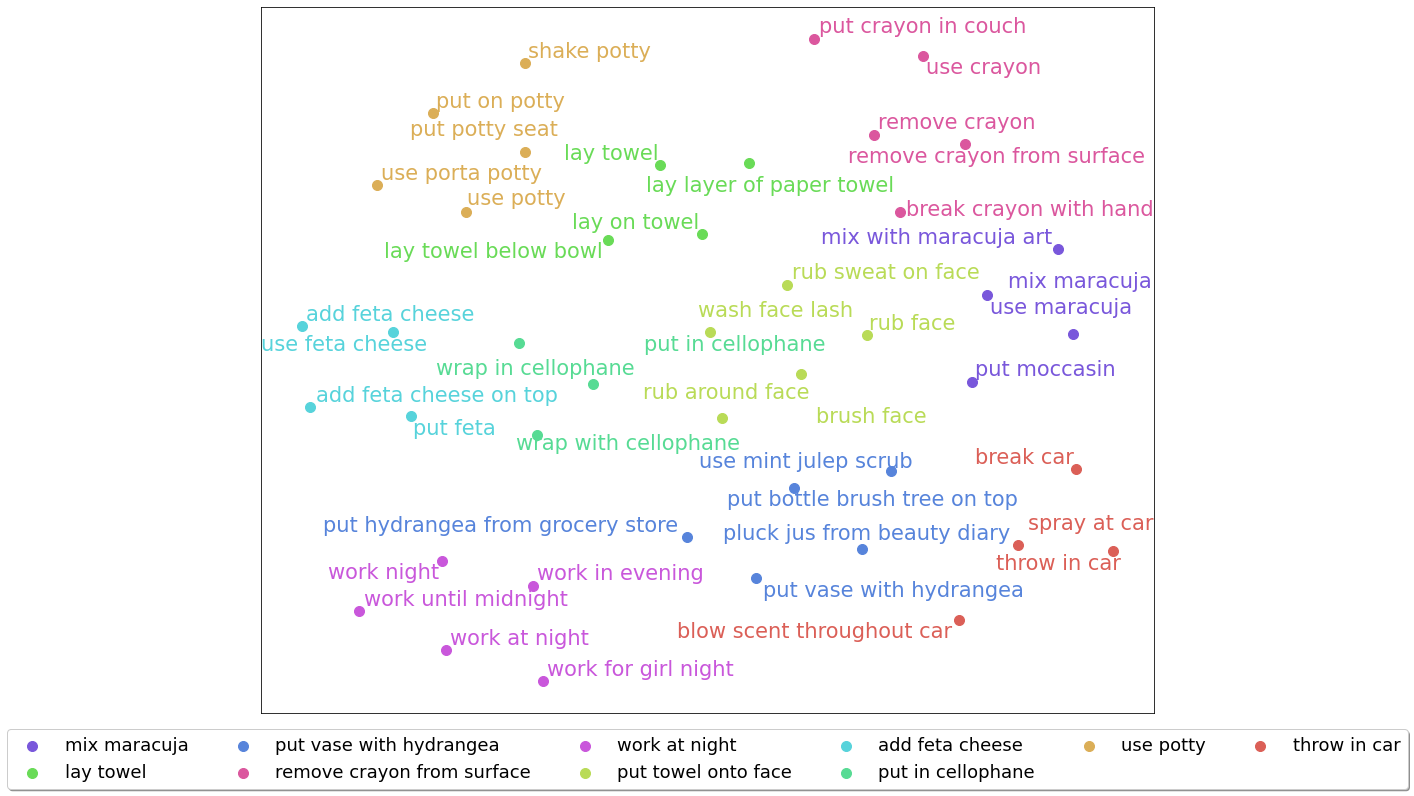

In [33]:
sentence_embeddings_proj_2d = tsne.fit_transform(least_freq_sentence_embeddings)
tsne_plot_2d(least_freq_clusters, sentence_embeddings_proj_2d, least_freq_actions_clusters)

In [65]:
most_common_actions = [action for (action, count) in Counter(all_actions).most_common()]
most_common_actions
# all_actions = list(set(all_actions))
# len(all_actions)

['add water',
 'add to bowl',
 'put in oven',
 'cook for minute',
 'add ingredient',
 'use oil',
 'use water',
 'add cinnamon',
 'use avocado',
 'add garlic',
 'add salt',
 'wear makeup',
 'use banana',
 'cook on stove',
 'use almond milk',
 'add tomato',
 'add oil',
 'add potato',
 'add teaspoon of maple syrup',
 'load dishwasher',
 'add chicken',
 'brush tooth',
 'add onion',
 'add cup of oats',
 'use brush',
 'use coconut oil',
 'add egg',
 'put lid',
 'put in refrigerator',
 'use cloth',
 'wash face',
 'use butter',
 'chop onion',
 'put on top',
 'massage kale',
 'add to pan',
 'add olive oil',
 'wash dish',
 'add flavor',
 'add pepper',
 'use milk',
 'clean toilet',
 'add bean',
 'clean sink',
 'use tablespoon',
 'add vegetable',
 'use mushroom',
 'cook pasta',
 'cook chicken',
 'use blender',
 'add apple',
 'add honey',
 'use color',
 'eat food',
 'use vanilla extract',
 'light candle',
 'add coconut oil',
 'use purpose flour',
 'eat in day',
 'wash hair',
 'add sauce',
 'add of 

In [66]:
sentence_embeddings = model.encode(most_common_actions)

In [67]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np


#Normalize the embeddings to unit length
sentence_embeddings = sentence_embeddings /  np.linalg.norm(sentence_embeddings, axis=1, keepdims=True)

# clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3)

clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(most_common_actions[sentence_id])

print(len(clustered_sentences))
for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

44
Cluster  1
['add water', 'use water', 'wash face', 'wash dish', 'wash hair', 'use soap', 'use dish soap', 'use sponge', 'pour water', 'drink water', 'put in bathroom', 'use shampoo', 'wash hand', 'fill with water', 'use cleanser', 'wash sheet', 'add to bath', 'rinse with water', 'use on sink', 'spray toilet', 'use vacuum', 'use cleaner', 'fill pot with water', 'use in shower', 'use toilet paper roll', 'wash clothe', 'wash body', 'use purpose cleaning solution', 'wash item', 'kill bacteria', 'drain water', 'spray wall', 'wash bedding', 'use mop', 'cover with water', 'use enzyme cleaner', 'mop bathroom', 'use window cleaner', 'throw in wash', 'use conditioner', 'wash washer', 'fill rest with water', 'use eraser sponge', 'use filter', 'spray in area', 'add soap coloring', 'wash sink', 'use desert essence shampoo', 'toss rug into washer', 'throw in water', 'put bubble bath', 'use paint sponge', 'wash knob in water', 'pour color at time', 'roll over sink', 'remove with washcloth', 'drink